In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import scipy
import time
import pickle
import pandas as pd
from scipy.optimize import minimize

import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

from parsmooth._base import MVNStandard, FunctionalModel, MVNSqrt
from parsmooth.linearization import extended, cubature, unscented, gauss_hermite
from parsmooth.methods import iterated_smoothing
from bearing_data_pe import get_data, make_parameters, inverse_bearings


import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"  # add this
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"


In [8]:
s1 = jnp.array([-1., 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
dt = 0.01  # discretization time step
qc = 0.1  # discretization noise
qw = 0.1  # discretization noise

n_run = 10
Ts = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
r_true = 0.05

In [3]:
# Data = []
# for t, T in enumerate(Ts):
#     data = []
#     for i in range(n_run):
#         _, _, ys = get_data(x0, dt, r_true, T, s1, s2)
#         positions = inverse_bearings(ys, s1, s2)
#         states = jnp.concatenate([jnp.concatenate([jnp.zeros((1,2)), positions], axis = 0),
#                               jnp.zeros((T+1,3))], axis = 1)
#
#         initial_states =  MVNStandard(states,0.1*jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))
#         initial_states_sqrt = MVNSqrt(states,jnp.sqrt(0.1)*jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))
#         data.append({'ys': ys, 'initial_states': initial_states, 'initial_states_sqrt': initial_states_sqrt})
#     Data.append(data)
#
#
# with  open("outputs/ell-runtime-output/data.pkl", "wb") as open_file:
#     pickle.dump(Data, open_file)


with open("outputs/ell-runtime-output/data.pkl", "rb") as open_file:
    Data = pickle.load(open_file)

In [4]:
Q, _, observation_function, transition_function = make_parameters(qc, qw, r_true, dt, s1, s2)

chol_Q = jnp.linalg.cholesky(Q)

m0 = jnp.array([2., 0, 0, 0, 0])
P0 = jnp.diag(jnp.array([0.5**2, 0.5**2, 0.5**2, 0.5**2, 1.]))
chol_P0 = scipy.linalg.cholesky(P0)

init = MVNStandard(m0, P0)
chol_init = MVNSqrt(m0, chol_P0)


sqrt_transition_model = FunctionalModel(transition_function, MVNSqrt(jnp.zeros((5,)), chol_Q))
transition_model = FunctionalModel(transition_function, MVNStandard(jnp.zeros((5,)), Q))


In [5]:
@jax.jit
def runtime_get_ell_std_extended_par(observations, initial_points, iteration, prec_r):
    r = 1 / prec_r[0]
    R = jnp.diag(jnp.array([r ** 2, 0.1 ** 2]))
    observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

    _, ell = iterated_smoothing(observations, init, transition_model, observation_model,
                                               extended, initial_points, True,
                                               criterion=lambda i, *_: i < iteration,
                                               return_loglikelihood = True)
    return -ell

@jax.jit
def runtime_get_ell_std_cubature_par(observations, initial_points, iteration, prec_r):
    r = 1 / prec_r[0]
    R = jnp.diag(jnp.array([r ** 2, 0.1 ** 2]))
    observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

    _, ell = iterated_smoothing(observations, init, transition_model, observation_model,
                                               cubature, initial_points, True,
                                               criterion=lambda i, *_: i < iteration,
                                               return_loglikelihood = True)
    return -ell

@jax.jit
def runtime_get_ell_std_unscented_par(observations, initial_points, iteration, prec_r):
    r = 1 / prec_r[0]
    R = jnp.diag(jnp.array([r ** 2, 0.1 ** 2]))
    observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

    _, ell = iterated_smoothing(observations, init, transition_model, observation_model,
                                               unscented, initial_points, True,
                                               criterion=lambda i, *_: i < iteration,
                                               return_loglikelihood = True)
    return -ell

@jax.jit
def runtime_get_ell_std_gh_par(observations, initial_points, iteration, prec_r):
    r = 1 / prec_r[0]
    R = jnp.diag(jnp.array([r ** 2, 0.1 ** 2]))
    observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

    _, ell = iterated_smoothing(observations, init, transition_model, observation_model,
                                               gauss_hermite, initial_points, True,
                                               criterion=lambda i, *_: i < iteration,
                                               return_loglikelihood = True)
    return -ell

@jax.jit
def runtime_get_ell_std_extended_seq(observations, initial_points, iteration, prec_r):
    r = 1 / prec_r[0]
    R = jnp.diag(jnp.array([r ** 2, 0.1 ** 2]))
    observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

    _, ell = iterated_smoothing(observations, init, transition_model, observation_model,
                                               extended, initial_points, False,
                                               criterion=lambda i, *_: i < iteration,
                                               return_loglikelihood = True)
    return -ell

@jax.jit
def runtime_get_ell_std_cubature_seq(observations, initial_points, iteration, prec_r):
    r = 1 / prec_r[0]
    R = jnp.diag(jnp.array([r ** 2, 0.1 ** 2]))
    observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

    _, ell = iterated_smoothing(observations, init, transition_model, observation_model,
                                               cubature, initial_points, False,
                                               criterion=lambda i, *_: i < iteration,
                                               return_loglikelihood = True)
    return -ell

@jax.jit
def runtime_get_ell_std_unscented_seq(observations, initial_points, iteration, prec_r):
    r = 1 / prec_r[0]
    R = jnp.diag(jnp.array([r ** 2, 0.1 ** 2]))
    observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

    _, ell = iterated_smoothing(observations, init, transition_model, observation_model,
                                               unscented, initial_points, False,
                                               criterion=lambda i, *_: i < iteration,
                                               return_loglikelihood = True)
    return -ell

@jax.jit
def runtime_get_ell_std_gh_seq(observations, initial_points, iteration, prec_r):
    r = 1 / prec_r[0]
    R = jnp.diag(jnp.array([r ** 2, 0.1 ** 2]))
    observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

    _, ell = iterated_smoothing(observations, init, transition_model, observation_model,
                                               gauss_hermite, initial_points, False,
                                               criterion=lambda i, *_: i < iteration,
                                               return_loglikelihood = True)
    return -ell

In [6]:
#parallel
def func(method, lengths, data, n_runs=5, n_iter=15, sqrt=False, mth='extended-std-par'):
    SdR11s = []
    Times = []
    for t, _ in enumerate(lengths):
        print(f"Length {t+1} out of {len(lengths)}")
        sdR11_res = []
        run_times = []
        for i in range(n_runs):
            observations_slice = data[t][i]['ys']
            if sqrt:
                init_linearizations_states = data[t][i]['initial_states_sqrt']
                args = observations_slice, init_linearizations_states, n_iter
            else:
                init_linearizations_states = data[t][i]['initial_states']
                args = observations_slice, init_linearizations_states, n_iter
            r0 = np.array([10.])
            method_res = lambda r: method(*args,r)
            grad_func= jax.jit(jax.value_and_grad(method_res))
            gpu_grad_func = jax.jit(grad_func, backend="gpu")
            def wrap_func(r):
                loss, grad_val = gpu_grad_func(r)
                return np.array(loss, dtype=np.float64), np.array(grad_val, dtype=np.float64)
            tic = time.time()
            sdR11 = minimize(wrap_func, r0, jac=True, method="L-BFGS-B", bounds=[(0, 100)]).x
            toc = time.time()
            run_times.append(toc - tic)
            sdR11_res.append(sdR11)
            print(f"run {i+1} out of {n_runs}", end="\r")
        SdR11s.append(sdR11_res)
        Times.append(run_times)
        np.savez("outputs/ell-runtime-output/TIME-GPU-"+mth+"-"+str(t), time = np.array(run_times) )
        np.savez("outputs/ell-runtime-output/sdR11-GPU-"+mth+"-"+str(t), sdR11 = np.array(sdR11_res) )
    print()

    return np.array(Times), np.array(SdR11s)


In [12]:
# time_gpu_extended_std_par, sd_gpu_extended_std_par= func(runtime_get_ell_std_extended_par, Ts, Data, n_run,sqrt=False, mth='extended-std-par')
# np.savez("outputs/ell-runtime-output/TIME-GPU-extended-std-par",
#           time_gpu_extended_std_par = time_gpu_extended_std_par)
# np.savez("outputs/ell-runtime-output/sdR11-GPU-extended-std-par",
#           sd_gpu_extended_std_par = sd_gpu_extended_std_par)

Length 11 out of 3
Length 12 out of 3
Length 13 out of 3
run 10 out of 10


In [ ]:
# Parallel other Methods

In [7]:
# time_gpu_cubature_std_par, sd_gpu_cubature_std_par= func(runtime_get_ell_std_cubature_par, Ts, Data, n_run,sqrt=False, mth='cubature-std-par')
# np.savez("outputs/ell-runtime-output/TIME-GPU-cubature-std-par",
#           time_gpu_cubature_std_par = time_gpu_cubature_std_par)
# np.savez("outputs/ell-runtime-output/sdR11-GPU-cubature-std-par",
#           sd_gpu_cubature_std_par = sd_gpu_cubature_std_par)

Length 1 out of 13
Length 2 out of 13
Length 3 out of 13
Length 4 out of 13
Length 5 out of 13
Length 6 out of 13
Length 7 out of 13
Length 8 out of 13
Length 9 out of 13
Length 10 out of 13
Length 11 out of 13
Length 12 out of 13
Length 13 out of 13
run 10 out of 10


In [7]:
# time_gpu_unscented_std_par, sd_gpu_unscented_std_par= func(runtime_get_ell_std_unscented_par, Ts, Data, n_run,sqrt=False, mth='unscented-std-par')
# np.savez("outputs/ell-runtime-output/TIME-GPU-unscented-std-par",
#           time_gpu_unscented_std_par = time_gpu_unscented_std_par)
# np.savez("outputs/ell-runtime-output/sdR11-GPU-unscented-std-par",
#           sd_gpu_unscented_std_par = sd_gpu_unscented_std_par)

Length 1 out of 13
Length 2 out of 13
Length 3 out of 13
Length 4 out of 13
Length 5 out of 13
Length 6 out of 13
Length 7 out of 13
Length 8 out of 13
Length 9 out of 13
Length 10 out of 13
Length 11 out of 13
Length 12 out of 13
Length 13 out of 13
run 10 out of 10


In [7]:
# time_gpu_gh_std_par, sd_gpu_gh_std_par= func(runtime_get_ell_std_gh_par, Ts, Data, n_run,sqrt=False, mth='gh-std-par')
# np.savez("outputs/ell-runtime-output/TIME-GPU-gh-std-par",
#           time_gpu_gh_std_par = time_gpu_gh_std_par)
# np.savez("outputs/ell-runtime-output/sdR11-GPU-gh-std-par",
#           sd_gpu_gh_std_par = sd_gpu_gh_std_par)

Length 1 out of 13
Length 2 out of 13
Length 3 out of 13
Length 4 out of 13
Length 5 out of 13
Length 6 out of 13
Length 7 out of 13
Length 8 out of 13
Length 9 out of 13
Length 10 out of 13
Length 11 out of 13
Length 12 out of 13
Length 13 out of 13
run 10 out of 10


In [ ]:
# Sequential

In [7]:
# time_gpu_cubature_std_seq, sd_gpu_cubature_std_seq= func(runtime_get_ell_std_cubature_seq, Ts, Data, n_run, sqrt=False, mth='cubature-std-seq')
# np.savez("outputs/ell-runtime-output/TIME-GPU-cubature-std-seq",
#           time_gpu_cubature_std_seq = time_gpu_cubature_std_seq)
# np.savez("outputs/ell-runtime-output/sdR11-GPU-cubature-std-seq",
#           sd_gpu_cubature_std_seq = sd_gpu_cubature_std_seq)

Length 1 out of 13
Length 2 out of 13
Length 3 out of 13
Length 4 out of 13
Length 5 out of 13
Length 6 out of 13
Length 7 out of 13
Length 8 out of 13
Length 9 out of 13
Length 10 out of 13
Length 11 out of 13
Length 12 out of 13
Length 13 out of 13
run 10 out of 10


In [7]:
# time_gpu_unscented_std_seq, sd_gpu_unscented_std_seq= func(runtime_get_ell_std_unscented_seq, Ts, Data, n_run, sqrt=False, mth='unscented-std-seq')
# np.savez("outputs/ell-runtime-output/TIME-GPU-unscented-std-seq",
#           time_gpu_unscented_std_seq = time_gpu_unscented_std_seq)
# np.savez("outputs/ell-runtime-output/sdR11-GPU-unscented-std-seq",
#           sd_gpu_unscented_std_seq = sd_gpu_unscented_std_seq)

Length 1 out of 13
Length 2 out of 13
Length 3 out of 13
Length 4 out of 13
Length 5 out of 13
Length 6 out of 13
Length 7 out of 13
Length 8 out of 13
Length 9 out of 13
Length 10 out of 13
Length 11 out of 13
Length 12 out of 13
Length 13 out of 13
run 10 out of 10


In [7]:
# time_gpu_gh_std_seq, sd_gpu_gh_std_seq= func(runtime_get_ell_std_gh_seq, Ts, Data, n_run, sqrt=False, mth='gh-std-seq')
# np.savez("outputs/ell-runtime-output/TIME-GPU-gh-std-seq",
#           time_gpu_gh_std_seq = time_gpu_gh_std_seq)
# np.savez("outputs/ell-runtime-output/sdR11-GPU-gh-std-seq",
#           sd_gpu_gh_std_seq = sd_gpu_gh_std_seq)

Length 1 out of 13
Length 2 out of 13
Length 3 out of 13
Length 4 out of 13
Length 5 out of 13
Length 6 out of 13
Length 7 out of 13
Length 8 out of 13
Length 9 out of 13
Length 10 out of 13
Length 11 out of 13
Length 12 out of 13
Length 13 out of 13
run 10 out of 10


In [52]:
# time_gpu_extended_std_seq, sd_gpu_extended_std_seq= func(runtime_get_ell_std_extended_seq, Ts, Data, n_run, sqrt=False, mth='extended-std-seq')
# np.savez("outputs/ell-runtime-output/TIME-GPU-extended-std-seq",
#           time_gpu_extended_std_seq = time_gpu_extended_std_seq)
# np.savez("outputs/ell-runtime-output/sdR11-GPU-extended-std-seq",
#           sd_gpu_extended_std_seq = sd_gpu_extended_std_seq)

Length 12 out of 2
Length 13 out of 2
run 10 out of 10


In [53]:
mth='extended-std-seq'
time_gpu_extended_std_seq = []
sd_gpu_extended_std_seq = []
for t in range(len(Ts)):
    with np.load("outputs/ell-runtime-output/TIME-GPU-"+mth+"-"+str(t)+".npz") as loaded:
        time_gpu_extended_std_seq.append(loaded["time"])
    with np.load("outputs/ell-runtime-output/sdR11-GPU-"+mth+"-"+str(t)+".npz") as loaded:
        sd_gpu_extended_std_seq.append(loaded["sdR11"])

# np.savez("outputs/ell-runtime-output/TIME-GPU-extended-std-seq",
#           time_gpu_extended_std_seq = time_gpu_extended_std_seq)
# np.savez("outputs/ell-runtime-output/sdR11-GPU-extended-std-seq",
#           sd_gpu_extended_std_seq = sd_gpu_extended_std_seq)

In [2]:
with np.load("outputs/ell-runtime-output/TIME-GPU-extended-std-par.npz") as loaded:
    time_extended_par=np.mean(loaded["time_gpu_extended_std_par"],axis=1)

with np.load("outputs/ell-runtime-output/TIME-GPU-extended-std-seq.npz") as loaded:
    time_extended_seq=np.mean(loaded["time_gpu_extended_std_seq"],axis=1)

with np.load("outputs/ell-runtime-output/TIME-GPU-cubature-std-par.npz") as loaded:
    time_cubature_par=np.mean(loaded["time_gpu_cubature_std_par"],axis=1)

with np.load("outputs/ell-runtime-output/TIME-GPU-cubature-std-seq.npz") as loaded:
    time_cubature_seq=np.mean(loaded["time_gpu_cubature_std_seq"],axis=1)

with np.load("outputs/ell-runtime-output/TIME-GPU-unscented-std-par.npz") as loaded:
    time_unscented_par=np.mean(loaded["time_gpu_unscented_std_par"],axis=1)

with np.load("outputs/ell-runtime-output/TIME-GPU-unscented-std-seq.npz") as loaded:
    time_unscented_seq=np.mean(loaded["time_gpu_unscented_std_seq"],axis=1)

with np.load("outputs/ell-runtime-output/TIME-GPU-gh-std-par.npz") as loaded:
    time_gh_par=np.mean(loaded["time_gpu_gh_std_par"],axis=1)

with np.load("outputs/ell-runtime-output/TIME-GPU-gh-std-seq.npz") as loaded:
    time_gh_seq=np.mean(loaded["time_gpu_gh_std_seq"],axis=1)

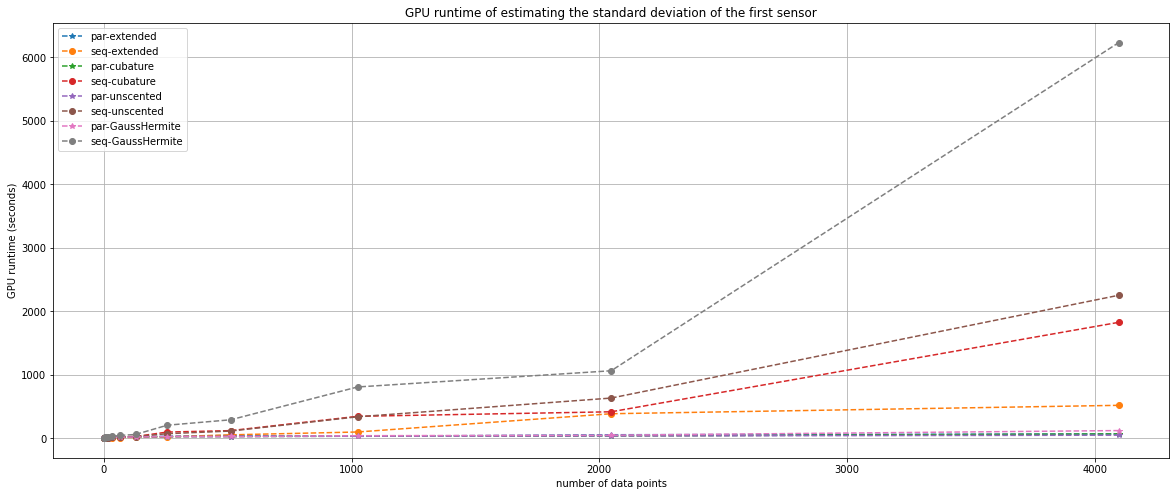

In [5]:
plt.figure(figsize=(20,8))
plt.plot(np.array(Ts), time_extended_par, "*--", label = "par-extended")
plt.plot(np.array(Ts), time_extended_seq, "o--", label = "seq-extended")
plt.plot(np.array(Ts), time_cubature_par, "*--", label = "par-cubature")
plt.plot(np.array(Ts), time_cubature_seq, "o--", label = "seq-cubature")
plt.plot(np.array(Ts), time_unscented_par, "*--", label = "par-unscented")
plt.plot(np.array(Ts), time_unscented_seq, "o--", label = "seq-unscented")
plt.plot(np.array(Ts), time_gh_par, "*--", label = "par-GaussHermite")
plt.plot(np.array(Ts), time_gh_seq, "o--", label = "seq-GaussHermite")
plt.title("GPU runtime of estimating the standard deviation of the first sensor")
plt.xlabel("number of data points")
plt.ylabel("GPU runtime (seconds)")
plt.grid()
plt.legend();

In [25]:
# plt.figure(figsize=(20,8))
# plt.plot(np.array(Ts)[[0,1,8,10,11]], time1[[0,1,8,10,11]], "*--", label = "par")
# plt.plot(np.array(Ts)[[0,1,8,10,11]], time2[[0,1,8,10,11]], "o--", label = "seq")
# plt.grid()
# plt.legend();

In [48]:
with np.load("outputs/ell-runtime-output/sdR11-GPU-extended-std-par.npz") as loaded:
    sdR11_1=loaded["sd_gpu_extended_std_par"]

rmse_extended_par = np.mean(np.abs(1/np.array(sdR11_1).squeeze()-r_true)**2,axis=1)**0.5

with np.load("outputs/ell-runtime-output/sdR11-GPU-extended-std-seq.npz") as loaded:
    sdR11_2=loaded["sd_gpu_extended_std_seq"]

rmse_extended_seq = np.mean(np.abs(1/np.array(sdR11_2).squeeze()-r_true)**2,axis=1)**0.5

with np.load("outputs/ell-runtime-output/sdR11-GPU-cubature-std-seq.npz") as loaded:
    sdR11_6=loaded["sd_gpu_cubature_std_seq"]

rmse_cubature_seq = np.mean(np.abs(1/np.array(sdR11_6).squeeze()-r_true)**2,axis=1)**0.5

with np.load("outputs/ell-runtime-output/sdR11-GPU-cubature-std-par.npz") as loaded:
    sdR11_3=loaded["sd_gpu_cubature_std_par"]

rmse_cubature_par = np.mean(np.abs(1/np.array(sdR11_3).squeeze()-r_true)**2,axis=1)**0.5

with np.load("outputs/ell-runtime-output/sdR11-GPU-unscented-std-par.npz") as loaded:
    sdR11_4=loaded["sd_gpu_unscented_std_par"]

rmse_unscented_par = np.mean(np.abs(1/np.array(sdR11_4).squeeze()-r_true)**2,axis=1)**0.5

with np.load("outputs/ell-runtime-output/sdR11-GPU-gh-std-par.npz") as loaded:
    sdR11_5=loaded["sd_gpu_gh_std_par"]

rmse_gh_par = np.mean(np.abs(1/np.array(sdR11_5).squeeze()-r_true)**2,axis=1)**0.5

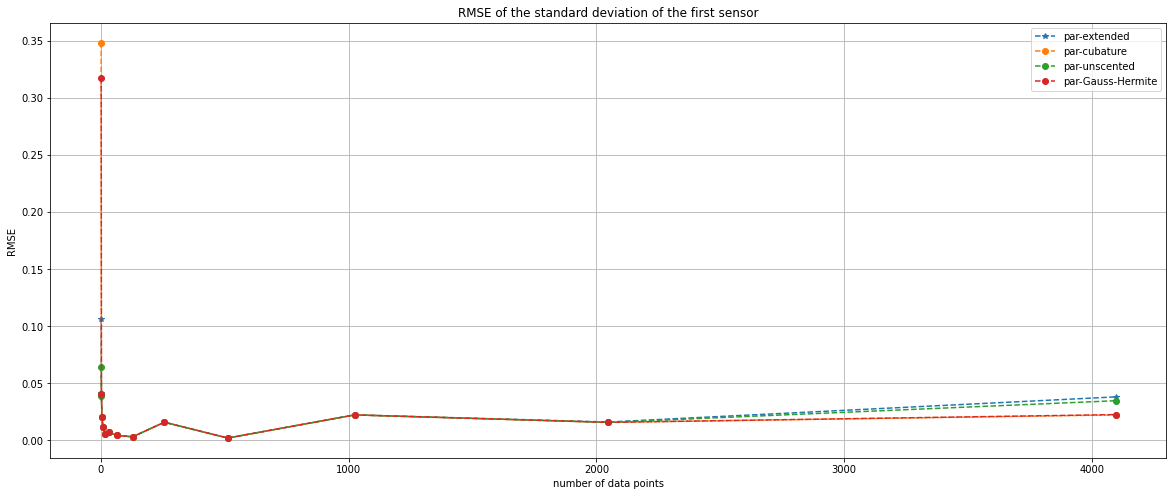

In [49]:
plt.figure(figsize=(20,8))
plt.plot(np.array(Ts), rmse_extended_par, "*--", label = "par-extended")
plt.plot(np.array(Ts), rmse_cubature_par, "o--", label = "par-cubature")
plt.plot(np.array(Ts), rmse_unscented_par, "o--", label = "par-unscented")
plt.plot(np.array(Ts), rmse_gh_par, "o--", label = "par-Gauss-Hermite")
plt.title("RMSE of the standard deviation of the first sensor")
plt.xlabel("number of data points")
plt.ylabel("RMSE")
plt.grid()
plt.legend();

In [6]:
data_csv_time = np.stack([Ts,
                 time_extended_par,
                 time_extended_seq,
                 time_cubature_par,
                 time_cubature_seq,
                 time_gh_par,
                 time_gh_seq],
                axis=1)

columns = ["time_steps",
           "time_extended_par",
           "time_extended_seq",
           "time_cubature_par",
           "time_cubature_seq",
           "time_gh_par",
           "time_gh_seq"]

df = pd.DataFrame(data=data_csv_time, columns=columns)
df.to_csv("outputs/ell-runtime-output/GPU_sdR11_runtime.csv")

In [50]:
data_csv_sdR11 = np.stack([Ts,
                 rmse_extended_par,
                 rmse_cubature_par,
                 rmse_unscented_par,
                 rmse_gh_par],
                axis=1)

columns_sdR11 = ["time_steps",
           "rmse_extended_par",
           "rmse_cubature_par",
           "rmse_unscented_par",
           "rmse_gh_par"]

df_rmse = pd.DataFrame(data=data_csv_sdR11, columns=columns_sdR11)
# df_rmse.to_csv("outputs/ell-runtime-output/GPU_sdR11_rmse.csv")